# Retrieve and visualize sweep results
In our setup, each job computes an embedding for a given method and parameter combination in isolation and send the results to wandb. There are plently of ways to visualize the results on the wandb dashbord, for example parallel coordinate plots, which help to understand paramter importance. 

However, the scIB results on wandb don't have the usual min-max column scaling that's frequently used in plots, because such scaling requires all results to be available at once, while each of our jobs only has access to a single run. Here we'll aggregate sweep results from wandb and visualize them jointly with the usual min-max column scaling. 

## Preliminaries

### Library imports

`autoreload` to re-load packages. 

In [1]:
%load_ext autoreload
%autoreload 2

The actual imports. 

In [2]:
import warnings

from scembed import scIBAggregator

/cluster/project/treutlein/USERS/mlange/miniforge3/envs/slurm_sweep/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Main

### Fetch runs from weights and biases (wandb)

Specify the details of your project first. 

In [3]:
agg = scIBAggregator(entity="spatial_vi", project="scembed_test")
agg

INFO     Initialized scIBAggregator for spatial_vi/scembed_test                                                    


scIBAggregator(spatial_vi/scembed_test, no data fetched)

Now, fetch all runs for this project, across all sweeps. 

In [4]:
agg.fetch_runs()

INFO     Fetching runs from spatial_vi/scembed_test...                                                             


Processing runs: 100%|██████████| 25/25 [00:00<00:00, 9395.00it/s]

INFO     Fetched 25 runs                                                                                           
WARNING  Filtered out 1 runs with missing/invalid configs: ['6kbbkq6o']                                            
INFO     Available scIB metrics: ['BRAS', 'Graph connectivity', 'KBET', 'KMeans ARI', 'KMeans NMI', 'PCR           
         comparison', 'Silhouette label', 'cLISI', 'iLISI']                                                        
INFO     Processing complete: 7 methods, 1 runs filtered out                                                       


We can now print the object again to get some more info. 

In [5]:
print(agg)

scIBAggregator(spatial_vi/scembed_test, 24/25 runs, 7 methods, 9 metrics (1 missing configs))


### Inspect individual method

First, let's look at an individual method to understand how different parameters influence performance. Method data is stored in `agg.method_data`: 

In [6]:
agg.method_data.keys()

dict_keys(['liger', 'pca', 'scanorama', 'harmony', 'scvi', 'scanvi', 'scpoli'])

Let's take a look at this for `harmony`. 

In [7]:
agg.method_data["harmony"].keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

The `scib_benchmarker` object can be used just like the regular scIB output: 

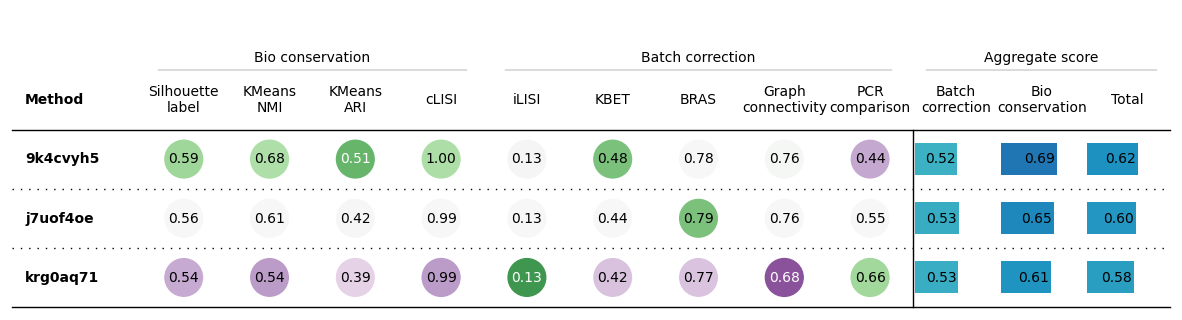

In [8]:
agg.method_data["harmony"]["scib_benchmarker"].plot_results_table(min_max_scale=False)

The differences aren't hughe, but we can still take a look at the corresponding configs. 

In [9]:
agg.method_data["harmony"]["configs"]

,method,k,lambda_reg,alpha,sigma,theta,n_latent,n_layers,max_epochs_scanvi,n_epochs,embedding_dims,pretraining_epochs
run_id,,,,,,,,,,,,
9k4cvyh5,harmony,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
j7uof4oe,harmony,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
krg0aq71,harmony,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN


It looks like `theta=1` works best in this case. 

### Aggregate results across methods

The main thing we want to get out if of course which method workes best on this dataset. For this, we call `.aggregate`, which selects the best performing run per method. 

In [10]:
agg.aggregate()

INFO     Aggregated best runs for 7 methods using metric 'Total'                                                   


Now, there's a `.results` attribute that looks just like the methods above:

In [11]:
agg.results.keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

Again, the `scib_bencharker` be be used like regular scIB output. 

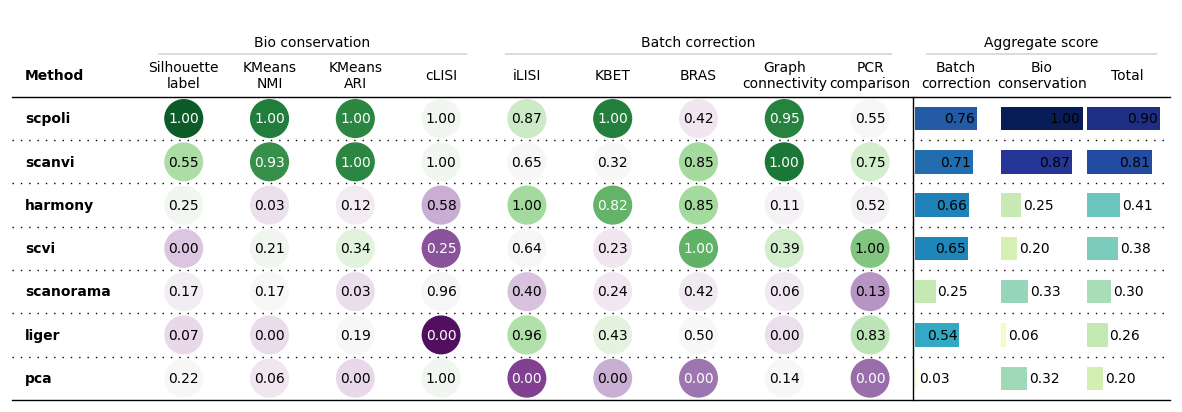

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    agg.results["scib_benchmarker"].plot_results_table(min_max_scale=True)

It looks like we have a clear winner here. Again, we can take a look at the corresponding config for each of these best performing runs. 

In [13]:
agg.results["configs"]

,method,k,lambda_reg,alpha,sigma,theta,n_latent,n_layers,max_epochs_scanvi,n_epochs,embedding_dims,pretraining_epochs
liger,liger,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pca,pca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scanorama,scanorama,NaN,NaN,0.1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
harmony,harmony,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
scvi,scvi,NaN,NaN,NaN,NaN,NaN,50.0,1.0,NaN,NaN,NaN,NaN
scanvi,scanvi,NaN,NaN,NaN,NaN,NaN,30.0,2.0,50.0,NaN,NaN,NaN
scpoli,scpoli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,10.0,40.0


We can also just get the aggregated results dataframe. 

In [14]:
agg.results["scib_benchmarker"].get_results()

,Silhouette label,KMeans NMI,KMeans ARI,cLISI,iLISI,KBET,BRAS,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,
liger,0.548596,0.670398,0.523743,0.992377,0.12526,0.359391,0.646403,0.732332,0.707661,0.514209,0.683779,0.615951
pca,0.585415,0.682006,0.476682,1.0,0.008071,0.223213,0.460335,0.764946,0.0,0.291313,0.686026,0.528141
scanorama,0.572915,0.701,0.485067,0.999717,0.056959,0.29889,0.618704,0.745705,0.113986,0.366849,0.689675,0.560544
harmony,0.592363,0.67637,0.506747,0.996828,0.130155,0.483755,0.777517,0.757674,0.44453,0.518726,0.693077,0.623337
scvi,0.531914,0.708962,0.562008,0.994288,0.086582,0.294934,0.834698,0.821408,0.853097,0.578144,0.699293,0.650833
scanvi,0.663006,0.839212,0.724349,1.0,0.08706,0.323128,0.777304,0.960428,0.641718,0.557928,0.806642,0.707156
scpoli,0.770384,0.852753,0.724225,1.0,0.114204,0.540029,0.616068,0.950042,0.469229,0.537914,0.836841,0.71727
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score
